# Binning part 2: create bins with `metabat2`

Now, we continue the binning procedure with `metabat2`.
In this notebook, we will create the actual bins! 
We will need:
* The scaffolds of the assembly, to bin.
* The depth matrix we made with the jgi script in binning part1.
* A new folder, to store the newly created bins.

First, remember where the first two items listed above are. 
Use `ls` to confirm in the cell below.

**[DO:] Locate the scaffolds file:**

In [1]:
ls data/assembly

scaffolds.fasta      scaffolds.fasta.bwt  scaffolds.fasta.sa
scaffolds.fasta.amb  scaffolds.fasta.gz
scaffolds.fasta.ann  scaffolds.fasta.pac


**[DO:] Locate the depth matrix:**

In [2]:
ls data/depth_matrix.tab

data/depth_matrix.tab


**[DO:] Make a new directory to store your bins.** 
Make sure this directory is `data/bins`

In [3]:
mkdir data/bins

**[DO:] Read the help page of** `metabat2`

Find out which options you have to use minimally, then make sure you tell MetaBAT to use one thread only!

Supply your depth matrix as the --abdFile. Short for AbundanceFile.

In [4]:
metabat2 -h


MetaBAT: Metagenome Binning based on Abundance and Tetranucleotide frequency (version 2:2.15 (Bioconda); 2020-01-04T21:10:40)
by Don Kang (ddkang@lbl.gov), Feng Li, Jeff Froula, Rob Egan, and Zhong Wang (zhongwang@lbl.gov) 

Allowed options:
  -h [ --help ]                     produce help message
  -i [ --inFile ] arg               Contigs in (gzipped) fasta file format [Mandatory]
  -o [ --outFile ] arg              Base file name and path for each bin. The default output is fasta format.
                                    Use -l option to output only contig names [Mandatory].
  -a [ --abdFile ] arg              A file having mean and variance of base coverage depth (tab delimited; 
                                    the first column should be contig names, and the first row will be 
                                    considered as the header and be skipped) [Optional].
  -m [ --minContig ] arg (=2500)    Minimum size of a contig for binning (should be >=1500).
  --maxP arg (=95)

**[DO:] Bin your scaffolds with** `metabat2` **:**

In [5]:
metabat2 -i ./data/assembly/scaffolds.fasta -o ./data/bins/bin -a ./data/depth_matrix.tab

MetaBAT 2 (2.15 (Bioconda)) using minContig 2500, minCV 1.0, minCVSum 1.0, maxP 95%, minS 60, maxEdges 200 and minClsSize 200000. with random seed=1647960494
6 bins (25241689 bases in total) formed.


**[DO:] How many bins were created?** 
Check the directory where you stored your bins.

**[Q:] Did you get more or less bins than expected from the length/depth plot you made earlier?**

**[A:]**

The depth/length plot we made in python showed three main clusters, hence we get more bins than expected from that plot. 

However, the advanced plot with taxonomy added indicated at least 4 abundant bins, and possible 4 or more low abundant bins. In that case we get less bins than we had expected. 

See [the answers of notebook m04](https://lauralwd.github.io/metagenomicspractical/practical_example/m04-plot_assembly_length.html) for more details.

## visualisation
Now we have our metagenome binned!
Congratulations.
Let's try to visualise this similarly as done in Binning part 1. 
We will use some command line tricks to get all data in a similar sheet.
In this case, these are given to you already.
If you feel up to the challenge, try to reverse engineer the code and understand what is happening.

**[DO:] Run the code below to make** `data/binlist.txt`

In [6]:
# First, we make an empty file with a header in which we will make our table. 
echo -e 'bin\tcontigName' > binlist
# Then we move to the folder in which we made the bins. 
cd ./data/bins/
# Now, we start a loop for each file that ends with `.fa`
for f in *.fa
do  # For each `.fa` file, we extract the bin number and make a variable that we call `name`
    name=$(echo $f | cut -d '.' -f 2)
    # Continuing in this iteration of the loop, we filter all fasta headers
    grep '>' $f | sed "s/^>/$name\t/g"
done | sort -k2 -V >> ../binlist.txt
# directly after filtering, replace the fasta header sign '>' with the `name` variable defined earlier.
# we end the loop and sort all resulting tables at once on the second column 
# after sorting, we append our newly made table to the 'binlist' file we defined earlier.
cd ../../

**[DO:] Check what the file looks like:**

In [7]:
head data/binlist.txt

bin	contigName
4	NODE_1_length_1935275_cov_24.6805_ID_23901540
4	NODE_2_length_1021023_cov_23.722_ID_28578184
4	NODE_3_length_872793_cov_26.0458_ID_35712810
4	NODE_4_length_853167_cov_25.0814_ID_23902252
1	NODE_5_length_723368_cov_22.0639_ID_32380821
6	NODE_6_length_592196_cov_27.8287_ID_32359880
1	NODE_8_length_486458_cov_22.6157_ID_32183008
4	NODE_9_length_472787_cov_23.2794_ID_23901976
6	NODE_13_length_350638_cov_27.7245_ID_23902421


**[DO:] compare these with the names we have in our depth_matrix.txt.**
They must be exactly the same to join these two different tables into one.

In [8]:
cut -f 1  data/depth_matrix.tab | head

contigName
NODE_1_length_1935275_cov_24.6805_ID_23901540
NODE_2_length_1021023_cov_23.722_ID_28578184
NODE_3_length_872793_cov_26.0458_ID_35712810
NODE_4_length_853167_cov_25.0814_ID_23902252
NODE_5_length_723368_cov_22.0639_ID_32380821
NODE_6_length_592196_cov_27.8287_ID_32359880
NODE_7_length_571573_cov_24.8726_ID_32329659
NODE_8_length_486458_cov_22.6157_ID_32183008
NODE_9_length_472787_cov_23.2794_ID_23901976
cut: write error: Broken pipe


Now, we use the `join` command to join the two tables.
There must be a shared field in both tables.
In the first table, this is the second column `-1 2`, and in the second file, this is the first column `-2 1`. 

We then take both files and give them to the join command.
However, since `join` is very picky in how files are sorted, we re-sort them on-the-fly like so ` <(sort -k2d ./somefile.txt)` (second column, sort as dictionary).

Lastly, since both files have headers, we supply the `--header` option and save the result as a new file.

Notice that I use the `\` character to spread out this very long `join` commandline over several lines.

**[DO:] fill in the path to your depth matrix below and run the code**

In [13]:
join -1 2 -2 1                                         \
     <(sort -k2d ./data/binlist)                       \
     <(sort -k1d <<...your original depth matrix...>>) \
     --header                                          \
     | tr ' ' "\t"                                     \
     > ./data/binned_depth_matrix.tab 

**[DO:] Visualise the binned_depth_matrix.tab in excel**
1. Like we did before, download this resulting table `binned_depth_matrix.tab` and open it in excel.
2. Sort the file by the bin number. 
3. Erase columns you do not want to visualise
4. Use conditional formatting to visualise depth profiles over the different samples per bin. 

**[Q:] Does this colour pattern make more sense than it did before?**

**[A:]** Yes, when sorting on bin number rows with similar colour patterns are grouped together.

**[Q:] Are there any outliers or mistakes you can spot?**

**[A:]** Yes, some rows don't share the colour pattern of the majority of rows in a certain bin. These might be wrongfully clustered in that bin. Perhaps the algorithm clustered these together based on k-mer profiles.

# [Example sheet](https://docs.google.com/spreadsheets/d/1Cdkl8dT75CETGUA_l52Gh8g8qtWd9vv4QAGtTe9HpPU/edit?usp=sharing)

## Bin depth
**[Q:]Can you determine the depth of the six bins from this table? Why is this not taking the mean of all depths?**
Think about the difference between depth and coverage.
You will need to make a pivot table in excel/LibreOffice/googledrive.


**[A:]**
Making sure to correct for contig length, the depth per bin looks like the table below.
Note that bin numbers may not coincide for your particular binning!
This is normal behaviour.

bin	|Bin Depth
 ---|---
1	|205.48
2	|5.00
3	|3.53
4	|3.87
5	|4.28
6	|4.62

**[Q:] Can you determine the depth of each bin per sample(type)?**
In other words, which bin is abundant in the L samples, and which bin is abundant in the P samples.


**[A:]** This takes some excel or R magic but it is possible for sure. See the example sheet linked above to see how I appreached this. The final table looks like this:

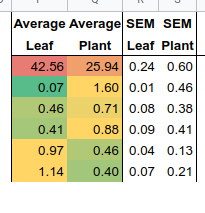

In this particular order of bins, bin nr1 is clearly the most abundant and enriched inside the leaf (L) samples of the plant.

Bins 2 to 4 are substantially less abundant and seem to be less abundant in the L samples than the P samples. 
The bacteria corresponding with these genomes are likely living outside the plant.
Bin 5 and 6 are also lowly abundant, but they are enriched inside the leaf samples. 
The bacteria corresponding with these genomes are likely living inside the plant leaves.

**[Q:] The research this practical is based on focusses on microbes inside the leaves (L samples).
Which bins would you advise me to study further?**

**[A:]**
Bin 5 and 6, these are bacteria enriched inside the leaves of the plant.

# Bonus: vary binning signals

If you'd like, you can try to vary input signals. 
For each variation, make sure you save the bins in a separate directory with a clear name.
* First, you can try to run metabat2 without the depth matrix. How many bins do you get then?
* You can edit the depth matrix to only contain samples from one type (E or P)
* You can edit the depth matrix to only contain one replicate per sample type, or two replicates?

To modify your depth matrix, have a look at the collumns present:
```
head -n 3 <<your depth matrix>>
```

You can select certain columns with the cut command.
This example shows you how to select only one replicate of one sample type and save this as a separate depth matrix.

```
cut -f 1-3,10,11 data/depth_matrix > data/depth_matrix_P1
```